In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-22e7dde2-a8ba-7477-c18e-e025fcbcf49c)


In [2]:
import datetime
print(f'Notebook last ran: {datetime.datetime.now()}')

Notebook last ran: 2023-07-10 15:20:19.118572


In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.01 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
import os

data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
os.listdir(data_dir)

['dev.txt', 'train.txt', 'test.txt']

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Preprocessing data

In [7]:
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [8]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = '' # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [10]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 607 ms, sys: 101 ms, total: 707 ms
Wall time: 1.23 s


(180040, 30212, 30135)

In [11]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(3)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11


In [13]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0: Baseline

In [18]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

CPU times: user 3.9 s, sys: 59.8 ms, total: 3.96 s
Wall time: 4.42 s


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [20]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [21]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-10 15:20:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-10 15:20:57 (79.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [22]:
from helper_functions import calculate_results

In [23]:
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

In [24]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Preparing data for deep sequence models

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

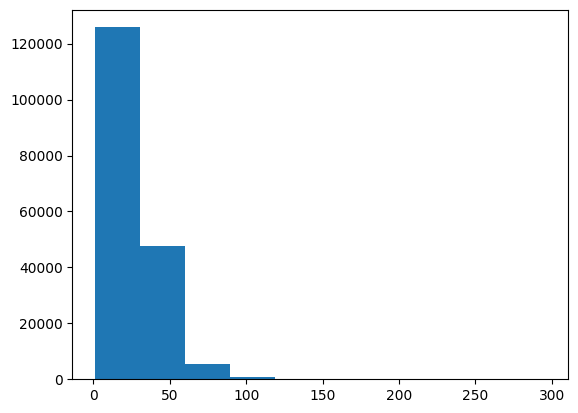

In [27]:
plt.hist(sent_lens);

In [28]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

## Create text vectorizer

In [31]:
from tensorflow.keras.layers import TextVectorization

In [33]:
max_tokens = 68000
text_vectorizer = TextVectorization(max_tokens = max_tokens, #numbers of words in vocabulary
                                    output_sequence_length = 55) #desired output length of vectorized sequences

In [34]:
text_vectorizer.adapt(train_sentences)

In [35]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [36]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

## Create embedding layer

Deep learning models requires data to be in numerical format, words do not fit that criteria. What embedding layers do is map words into dense numerical vectors, each word or token is represented by a unique vector in a high-dimensional space. The embedding vectors are learned during the training process and capture semantic or contextual relationships between words.

In [37]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = 'token_embedding')

## Creating datasets (tensorflow pipeline)

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

In [40]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'Conv1D')

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [41]:
model_1.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325  

In [42]:
model_1.fit(train_dataset,
            steps_per_epoch = int(0.1 * len(train_dataset)),
            epochs = 3,
            validation_data = valid_dataset,
            validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 44s 59ms/step - loss: 0.8344 - accuracy: 0.6867 - val_loss: 0.5845 - val_accuracy: 0.7842
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.5761 - accuracy: 0.7873 - val_loss: 0.5433 - val_accuracy: 0.8052
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.5442 - accuracy: 0.7993 - val_loss: 0.5220 - val_accuracy: 0.8062


In [43]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5241 - accuracy: 0.8053


[0.524096667766571, 0.8053091764450073]

In [44]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[6.2259966e-01, 3.5421181e-02, 2.0481679e-03, 3.3858851e-01,
        1.3425119e-03],
       [2.4894181e-01, 5.9275556e-01, 1.1929952e-03, 1.5414123e-01,
        2.9683800e-03],
       [1.7398246e-01, 6.8083876e-03, 3.2732242e-03, 8.1525302e-01,
        6.8293535e-04],
       ...,
       [1.1820687e-04, 2.2450739e-03, 1.4110806e-02, 1.0178511e-04,
        9.8342413e-01],
       [1.2334425e-02, 5.2575934e-01, 3.9323442e-02, 1.5400522e-02,
        4.0718222e-01],
       [1.1717119e-02, 9.7542983e-01, 3.9742822e-03, 2.6213056e-03,
        6.2574642e-03]], dtype=float32)

In [45]:
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [46]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 80.53091486826428,
 'precision': 0.8030687586370149,
 'recall': 0.8053091486826427,
 'f1': 0.8032670908938083}

# Model 2: Feature extraction with pretrained token embeddings

In [47]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [48]:
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = 'relu')(pretrained_embedding)
outputs = layers.Dense(5, activation = 'softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'USE')

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_2.fit(train_dataset,
            steps_per_epoch = int(0.1 * len(train_dataset)),
            epochs = 3,
            validation_data = valid_dataset,
            validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 13ms/step - loss: 0.9172 - accuracy: 0.6496 - val_loss: 0.7958 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7675 - accuracy: 0.7021 - val_loss: 0.7528 - val_accuracy: 0.7025
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7499 - accuracy: 0.7129 - val_loss: 0.7370 - val_accuracy: 0.7124


In [49]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7382 - accuracy: 0.7151


[0.7382414937019348, 0.7151132225990295]

In [50]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[0.4305451 , 0.35535818, 0.00246912, 0.20344907, 0.00817855],
       [0.32452554, 0.52016324, 0.00372084, 0.14921992, 0.0023705 ],
       [0.23760723, 0.13753517, 0.01334343, 0.573787  , 0.03772718],
       ...,
       [0.00206107, 0.00608831, 0.06366992, 0.00093445, 0.9272463 ],
       [0.00531129, 0.04833186, 0.19239426, 0.00177262, 0.75219   ],
       [0.19974647, 0.3285409 , 0.40401536, 0.00604008, 0.06165709]],
      dtype=float32)

In [51]:
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [52]:
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.51132000529591,
 'precision': 0.715169129975443,
 'recall': 0.7151132000529591,
 'f1': 0.7119704745933743}

# Model 3: Conv1D with character embeddings

> hello -> [h,e,l,l,o]

In [53]:
def split_chars(text):
  return ''.join(list(text))

In [54]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [55]:
char_lens = [len(sentence) for sentence in train_sentences]
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [56]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [57]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # + space and OOV token [UNK]
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = 'lower_and_strip_punctuation',
                                    name = 'char_vectorizer')
char_vectorizer.adapt(train_chars)

In [58]:
char_vocab = char_vectorizer.get_vocabulary()

In [59]:
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                              output_dim = 25,
                              mask_zero = False,
                              name = 'char_embed')

In [60]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name = 'Conv1DCharEmbeddings')

model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_3.fit(train_dataset,
            epochs = 3,
            steps_per_epoch = int(0.1 * len(train_dataset)),
            validation_data = valid_dataset,
            validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 14ms/step - loss: 1.1165 - accuracy: 0.5596 - val_loss: 0.9006 - val_accuracy: 0.6336
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 0.8792 - accuracy: 0.6514 - val_loss: 0.8378 - val_accuracy: 0.6656
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.8474 - accuracy: 0.6664 - val_loss: 0.8138 - val_accuracy: 0.6852


In [61]:
model_3.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8171 - accuracy: 0.6824


[0.8171077370643616, 0.6823778748512268]

In [62]:
model_3_pred_probs = model_3.predict(valid_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.2236534 , 0.5490567 , 0.03854292, 0.1773846 , 0.01136234],
       [0.23641191, 0.61056995, 0.02521972, 0.10580128, 0.02199718],
       [0.4025151 , 0.17923352, 0.05232869, 0.35845366, 0.00746903],
       ...,
       [0.04394905, 0.14364514, 0.14646421, 0.0525577 , 0.61338395],
       [0.04023216, 0.4798624 , 0.05047939, 0.04136845, 0.38805756],
       [0.25734445, 0.20226356, 0.36520472, 0.08878689, 0.08640036]],
      dtype=float32)

In [63]:
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 1, 2])>

In [64]:
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 68.23778631007546,
 'precision': 0.6849135157628301,
 'recall': 0.6823778631007547,
 'f1': 0.6820548655208988}

# Model 4: Combining pretrained token embeddings + character embeddings

In [65]:
# Set up token inputs and model
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output, name = 'token_model')

# Set up character inputs and model
char_inputs = layers.Input(shape =(1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name = 'char_model')

# Concatenate both
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output, char_model.output])

# Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)

model_4 = tf.keras.Model([token_model.input, char_model.input],
                         output_layer,
                         name = 'model_4_token_char_embeds')

In [66]:
model_4.summary()

Model: "model_4_token_char_embeds"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

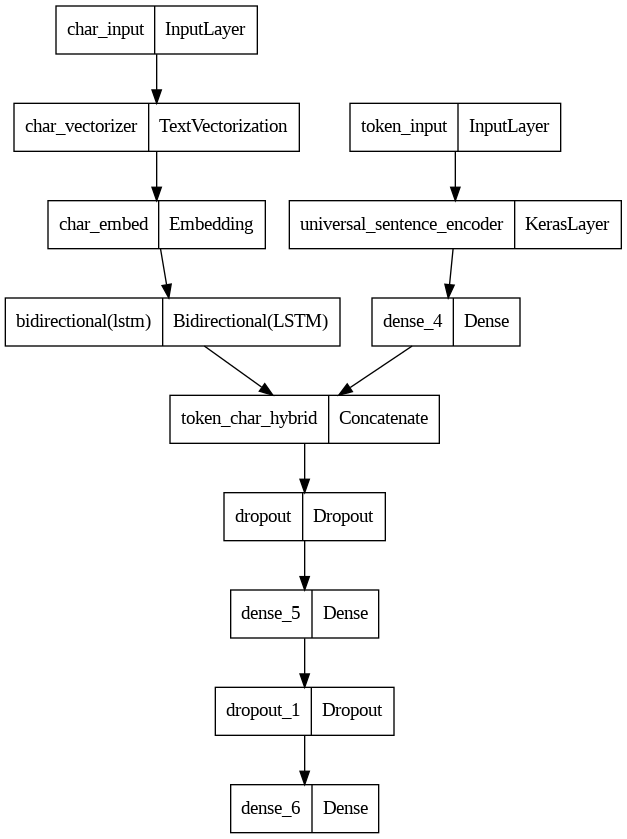

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [68]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [70]:
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 30s 42ms/step - loss: 0.9274 - accuracy: 0.6299 - val_loss: 0.7271 - val_accuracy: 0.7191
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7479 - accuracy: 0.7136 - val_loss: 0.6732 - val_accuracy: 0.7420
Epoch 3/3
562/562 [==============================] - 17s 31ms/step - loss: 0.7192 - accuracy: 0.7298 - val_loss: 0.6547 - val_accuracy: 0.7503


In [71]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.6531 - accuracy: 0.7488


[0.6531224846839905, 0.7488415241241455]

In [72]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 17s 17ms/step


array([[0.4760269 , 0.14744794, 0.00225605, 0.37149   , 0.00277916],
       [0.3122161 , 0.5623972 , 0.00444896, 0.11768434, 0.00325341],
       [0.2022291 , 0.04556997, 0.01765713, 0.72909176, 0.00545209],
       ...,
       [0.00576369, 0.03514125, 0.12796144, 0.00373097, 0.82740265],
       [0.01196125, 0.10417251, 0.12082903, 0.00778136, 0.7552558 ],
       [0.2729427 , 0.48130798, 0.18540376, 0.02720771, 0.03313782]],
      dtype=float32)

In [73]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [74]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.88415199258573,
 'precision': 0.7507202008775448,
 'recall': 0.7488415199258572,
 'f1': 0.7481563676466901}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [75]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [76]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [77]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)

In [78]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [79]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [82]:
# Token inputs
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Char inputs
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Line number inputs
line_number_inputs = layers.Input(shape = (15,), dtype = tf.int32, name = 'line_number_input')
x = layers.Dense(32, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# Total lines inputs
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.int32, name = 'total_lines_input')
y = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs = total_lines_inputs, outputs = y)

# Combine token and char embeds
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_embeds')([token_model.output, char_model.output])

z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)
z = layers.Concatenate(name = 'token_char_positional_embeds')([line_number_model.output,
                                                               total_line_model.output,
                                                               z])
output_layer = layers.Dense(5, activation = 'softmax', name = 'output_layer')(z)

model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_line_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer)

In [83]:
model_5.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [85]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [86]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 31s 42ms/step - loss: 0.7118 - accuracy: 0.7337 - val_loss: 0.5208 - val_accuracy: 0.8045
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.4805 - accuracy: 0.8190 - val_loss: 0.4530 - val_accuracy: 0.8261
Epoch 3/3
562/562 [==============================] - 20s 35ms/step - loss: 0.4415 - accuracy: 0.8273 - val_loss: 0.4326 - val_accuracy: 0.8265


In [87]:
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 25s 27ms/step - loss: 0.4281 - accuracy: 0.8339


[0.428069531917572, 0.8339070677757263]

In [88]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

945/945 [==============================] - 27s 28ms/step


array([[4.4309384e-01, 1.1288332e-02, 7.0363138e-05, 5.4535282e-01,
        1.9466340e-04],
       [6.3024837e-01, 1.5347000e-02, 1.5461723e-03, 3.5273358e-01,
        1.2479560e-04],
       [3.1209359e-01, 1.2271978e-02, 1.9112980e-02, 6.5349793e-01,
        3.0235827e-03],
       ...,
       [1.0787576e-03, 8.7113500e-02, 1.9474406e-02, 1.6654743e-04,
        8.9216679e-01],
       [1.4878444e-03, 2.8347394e-01, 2.0273298e-02, 1.8891806e-04,
        6.9457597e-01],
       [2.6523957e-01, 6.8558270e-01, 3.4318678e-02, 2.9719253e-03,
        1.1887112e-02]], dtype=float32)

In [89]:
model_5_pred = tf.argmax(model_5_pred_probs, axis = 1)
model_5_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 4, 1])>

In [91]:
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_pred)
model_5_results

{'accuracy': 83.39070567986231,
 'precision': 0.8350054115378042,
 'recall': 0.8339070567986231,
 'f1': 0.8341530392771428}

In [92]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,80.530915,0.803069,0.805309,0.803267
pretrained_token_embed,71.511320,0.715169,0.715113,0.711970
custom_char_embed_conv1d,68.237786,0.684914,0.682378,0.682055
hybrid_char_token_embed,74.884152,0.750720,0.748842,0.748156
tribrid_pos_char_token_embed,83.390706,0.835005,0.833907,0.834153


In [93]:
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [94]:
# Save to Google Drive
# !cp skimlit_best_model -r /content/drive/MyDrive/tensorflow_course/skim_lit

In [95]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [96]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 19s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0])>

In [97]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.85714285714286,
 'precision': 0.8295211156971066,
 'recall': 0.8285714285714286,
 'f1': 0.8287856932159604}

In [98]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-07-10 15:49:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-07-10 15:49:14 (46.0 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [99]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [100]:
from spacy.lang.en import English
nlp = English() # setup English sentence parser

In [101]:
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

In [117]:
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [113]:
total_lines_in_sample = len(abstract_lines)
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)

sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [114]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [115]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [118]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [119]:
%%time
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 1s/step
CPU times: user 1.22 s, sys: 10.4 ms, total: 1.23 s
Wall time: 1.23 s


array([[3.16208005e-01, 1.38531812e-02, 1.23164931e-03, 6.68040216e-01,
        6.66880689e-04],
       [7.23898457e-03, 1.19855795e-04, 9.68723416e-01, 8.32098629e-03,
        1.55968135e-02],
       [1.42858952e-01, 2.16047280e-03, 6.51689947e-01, 1.97612032e-01,
        5.67853265e-03],
       [1.10812388e-01, 2.20003445e-02, 7.28791416e-01, 8.55070576e-02,
        5.28888293e-02],
       [3.10265832e-03, 8.63211788e-03, 4.27246273e-01, 1.81207876e-03,
        5.59206843e-01],
       [3.01908678e-03, 1.16771804e-02, 8.28859806e-01, 1.18453556e-03,
        1.55259416e-01],
       [4.76501562e-04, 6.04997836e-02, 1.68563854e-02, 1.53671077e-04,
        9.22013700e-01],
       [4.86721925e-04, 2.73663588e-02, 1.48678243e-01, 2.58487329e-04,
        8.23210180e-01]], dtype=float32)

In [120]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [121]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [122]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
